In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import toolz
from itertools import product
from toolz import pluck

In [3]:
import algos
import features
import parametric
import policy
import chicken
from agents import OffPolicyAgent
from rlbench import *
from utils import *

In [4]:
class OffPolicyExperiment:
    def __init__(self, algo, env, policy_pi, policy_mu):
        self.algo = algo
        self.env = env
        self.pi = policy_pi
        self.mu = policy_mu
        
    def _run_episode(self, max_steps, params=dict()):
        ret = list()
        
        # reset the agent and the environment; perform the run
        t = 0
        self.agent.reset()
        self.env.reset()
        s = env.state
        while not env.is_terminal() and t < max_steps:
            actions = env.actions
            a = self.agent.choose(s, actions)
            r, sp = env.do(a)
            
            # update the agent
            self.agent.update(s, a, r, sp, **params)
            
            # get the context at the timestep
            ret.append(self.agent.get_context(s, a, r, sp))
            
            # prepare for next timestep
            t += 1
            s = sp
            
        # return the result
        return ret
    
    def setup_agent(self, params=dict()):
        self.phi = self.phi_cls(*self.phi_args, **self.phi_kwargs)
        learner = self.algo(self.phi.length)
        self.agent = OffPolicyAgent(learner, self.pi, self.mu, self.phi, params)
        
    def set_phi_class(self, phi_cls, *args, **kwargs):
        self.phi_cls = phi_cls
        self.phi_args = args
        self.phi_kwargs = kwargs
    
    def run(self, num_runs, max_steps, params):
        ret = []
        for i in range(num_runs):
            self.setup_agent(params=params)
            episode_data = dict()
            episode_data['features'] = {s: self.phi(s) for s in env.states}
            episode_data['steps'] = self._run_episode(max_steps)
            
        
            ret.append(episode_data)
        return ret

In [5]:
def tail_errors(data, last=1):
    errors = list()
    for episode in data:
        states = sorted(episode['features'].keys())
        X = np.array([episode['features'][s] for s in states]) 


        steps = episode['steps'][-last:]
        # compute the values for the tail end of the episode
        thetas = [x['theta'] for x in steps]
        values = [np.dot(X, theta) for theta in thetas]
        errors.append([err_func(v) for v in values])

    return np.array(errors)

In [6]:
def summarize(data, last=50):
    errors = list()
    for episode in data:
        states = sorted(episode['features'].keys())
        X = np.array([episode['features'][s] for s in states]) 


        steps = episode['steps'][-last:]
        # compute the values for the tail end of the episode
        thetas = [x['theta'] for x in steps]
        values = [np.dot(X, theta) for theta in thetas]
        errors.append([err_func(v) for v in values])

    errors = pd.Series(np.mean(errors, axis=1))
    ret = dict()
    ret['min'] = errors.min()
    ret['max'] = errors.max()
    ret['std'] = errors.std()
    ret['se'] = errors.sem()
    ret['mean'] = errors.mean()
    
    return ret

In [7]:
def enumerate_params(param_cases):
    names = list(param_cases.keys())
    cases = product(*[param_cases[k] for k in names])
    return [{k: v for k, v in zip(names, case)} for case in cases]

# True Values

The "true" values can be computed analytically in this case, so we did so.

We can also compute the distribution for weighting the errors.

# Comparing the Errors

For each algorithm, we get the associated experiment, and calculate the errors at each timestep, averaged over the runs performed with that algorithm.

In [8]:
# define the experiment
max_steps = 20000
num_runs = 5
num_last = 100
# define the environment
num_states = 8
# define the sort of feature function to use
num_features = 6
num_active = 3

# Hackish way of defining true values & distribution, but valid here
gamma = 0.9
true_values = gamma**np.arange(num_states)[::-1]
d_pi = np.ones(num_states)/num_states
D_pi = np.diag(d_pi)
print("True values:")
print(true_values)
print("On-policy distribution:")
print(d_pi)

# set up environment
env = chicken.Chicken(num_states)

# Define the target policy
pol_pi = policy.FixedPolicy({s: {0: 1} for s in env.states})
# Define the behavior policy
pol_mu = policy.FixedPolicy({s: {0: 1} if s < 4 else {0: 0.5, 1: 0.5} for s in env.states})

# state-dependent gamma
gm_dct = {s: 0.9 for s in env.states}
gm_dct[0] = 0
gm_func = parametric.MapState(gm_dct)
gm_p_func = parametric.MapNextState(gm_dct)

# problem parameters
problem_params = {
    'gm': gm_func,
    'gm_p': gm_p_func,
    'interest': 1.0,
}

True values:
[ 0.4782969  0.531441   0.59049    0.6561     0.729      0.81       0.9        1.       ]
On-policy distribution:
[ 0.125  0.125  0.125  0.125  0.125  0.125  0.125  0.125]


In [9]:
# setup error function
err_func = rmse_factory(true_values, d_pi)
baseline = err_func(np.zeros(num_states))

In [10]:
print(baseline)

0.258840084292


# GTD

In [11]:
# GTD
fixed_params = {
    'gm': gm_func,
    'gm_p': gm_p_func,
    'lm': 0.0,
    'lm_p': 0.0,
    'interest': 1.0,
}

param_grid = {
    'alpha': np.logspace(-0.5, -4, 10),
    'beta': np.logspace(-1, -4, 6),
}

cases = enumerate_params(param_grid)
ncases = len(cases)
experiment = OffPolicyExperiment(algos.GTD, env, pol_pi, pol_mu)
experiment.set_phi_class(features.RandomBinary, num_features, num_active)

df = pd.DataFrame(columns=['alpha', 'beta', 'min', 'max', 'mean', 'std', 'se'])


print("Iterating over parameters...")
for ix, case in enumerate(cases):
    print("Case #: {0:d} of {1:d}".format(ix, ncases), end='\r')
#     print('alpha: {alpha:10.6} {beta:10.6}'.format(**case))
    update_params = dict(**fixed_params, **case)
    data = experiment.run(num_runs, max_steps, update_params)
    
    dct = dict()
    dct.update(**case)
    dct.update(**summarize(data, num_last))
    
    df = df.append(dct, ignore_index=True)
    
    # is it still learning?
    avg_errors = np.mean(tail_errors(data, last=50), axis=0)
    grad = avg_errors[1:] - avg_errors[0:-1]
#     print(np.mean(grad))

# copy the dataframe in case additional analysis is desirable
df_gtd = df.copy()

# clip the 'mean' error 
df['mean'] = df['mean'].clip_upper(2)

print("Minimum error:")
print(df.sort_values('mean').head(1))

Iterating over parameters...
Minimum error:
       alpha      beta       min       max     mean       std        se
40  0.316228  0.000398  0.040518  0.193813  0.10013  0.062557  0.027976


In [12]:
# Sorting by mean instead
df.sort_values('mean').head(5)

,alpha,beta,min,max,mean,std,se
40,0.316228,0.000398,0.040518,0.193813,0.100130,0.062557,0.027976
31,0.129155,0.001585,0.058341,0.225616,0.136370,0.064498,0.028844
21,0.129155,0.006310,0.085436,0.211608,0.153365,0.063078,0.028209
41,0.129155,0.000398,0.140421,0.169510,0.157383,0.011567,0.005173
22,0.052750,0.006310,0.089030,0.195062,0.164678,0.042860,0.019167


In [13]:
# # Error surface (doesn't look right)
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.interpolate import griddata

# new_df = df.copy()
# new_df['mean'][new_df['mean'] >= 1] = 0.4
# X = new_df['alpha']
# Y = new_df['beta']
# Z = new_df['mean']
# Z[Z > 1] = Z[Z < 1].max()

# x1 = np.linspace(X.min(), X.max(), len(X.unique()))
# y1 = np.linspace(Y.min(), Y.max(), len(Y.unique()))
# x2, y2 = np.meshgrid(x1, y1)
# z2 = griddata((X, Y), Z, (x2, y2), method='cubic')


# ax = Axes3D(plt.figure())
# surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, linewidth=0, antialiased=False, cmap='coolwarm')

# ax.view_init(30, 210)
# plt.show()

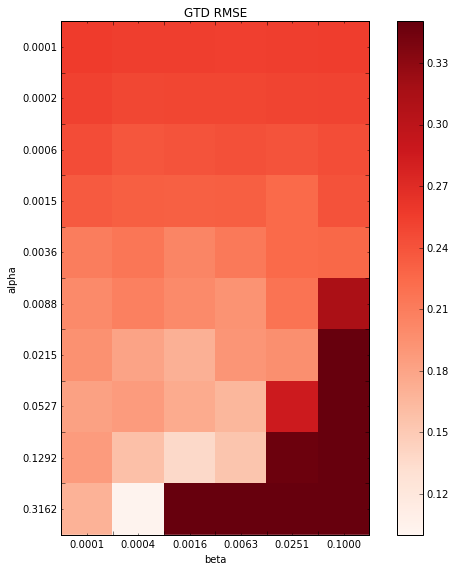

In [14]:
# Heat map
_df = df_gtd.copy()
xname = 'beta'
yname = 'alpha'

aa = np.sort(_df[xname].unique())
bb = np.sort(_df[yname].unique())
zz = _df['mean']
zz[zz > 1] = zz[zz < 1].max()

mat = np.zeros((len(aa), len(bb)))
for i, a in enumerate(aa):
    for j, b in enumerate(bb):
        val = zz[(_df[xname] == a) & (_df[yname] == b)].values
        mat[i,j] = val.mean()

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(mat.T, interpolation='none', cmap='Reds')

# Format the plot
ax.set_title('GTD RMSE')
ax.set_xlabel(xname)
ax.set_ylabel(yname)

# X-Axis ticks & labels
ax.set_xticks(np.arange(len(aa))-0.5)
ax.set_xticklabels([], visible=False)
ax.set_xticks(np.arange(len(aa)), minor=True)
ax.set_xticklabels(["{:2.4f}".format(i) for i in aa], minor=True)

# Y-axis
ax.set_yticks(np.arange(len(bb))-0.5)
ax.set_yticklabels([], visible=False)
ax.set_yticks(np.arange(len(bb)), minor=True)
ax.set_yticklabels(["{:2.4f}".format(i) for i in bb], minor=True, visible=True)

# add a colorbar
fig.colorbar(cax)

plt.tight_layout()
plt.show()

In [15]:
# _df[_df['alpha'] == np.sort(_df['alpha'].unique())[-3]]

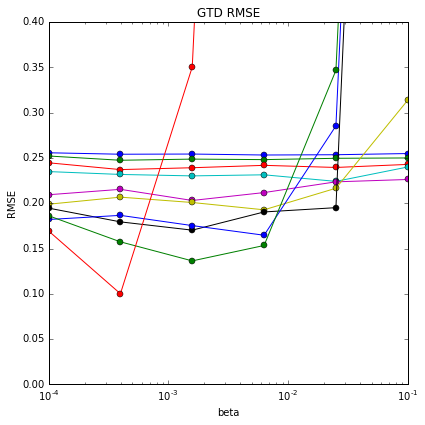

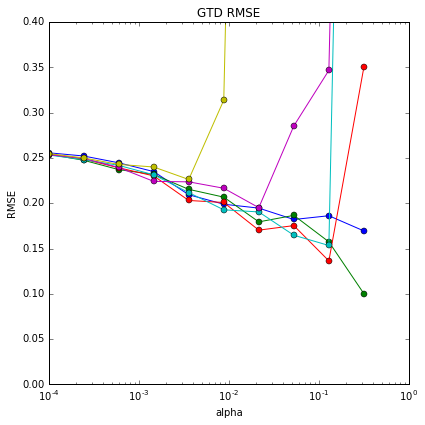

In [16]:
# One curve for each value of alpha
fig, ax = plt.subplots(1, figsize=(6,6))

groups = df.groupby('alpha')
for name, group in groups:
    length = len(group)
    xx = group['beta']
    yy = group['mean']
    ax.errorbar(xx, yy, fmt='-o')
    
    # format the graph
    ax.set_xscale('log')
    ax.set_xlim([xx.min(), xx.max()])
    ax.set_ylim([0, 0.4])
    
# Formatting
ax.set_title('GTD RMSE')
ax.set_xlabel('beta')
ax.set_ylabel('RMSE')
    
plt.tight_layout()
plt.show()

# One curve for each value of beta
fig, ax = plt.subplots(1, figsize=(6,6))

groups = df.groupby('beta')
for name, group in groups:
    length = len(group)
    xx = group['alpha']
    yy = group['mean']
    ax.errorbar(xx, yy, fmt='-o')
    
    # format the graph
    ax.set_xscale('log')
    ax.set_xlim([xx.min(), 1])
    ax.set_ylim([0, 0.4])
    
# Formatting
ax.set_title('GTD RMSE')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
    
plt.tight_layout()
plt.show()

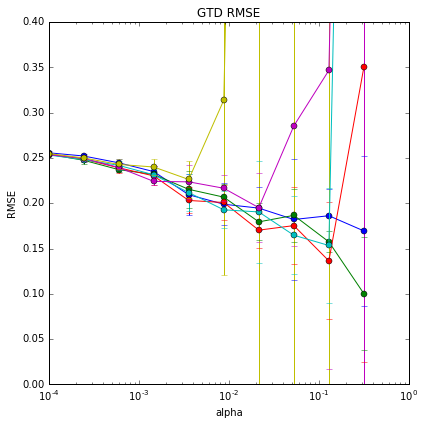

In [17]:
# One curve for each value of beta
fig, ax = plt.subplots(1, figsize=(6,6))

groups = df.groupby('beta')
for name, group in groups:
    length = len(group)
    xx = group['alpha']
    yy = group['mean']
    yerr = group['std'].values
    ax.errorbar(xx, yy, yerr=yerr, fmt='-o')
    
    # format the graph
    ax.set_xscale('log')
    ax.set_xlim([xx.min(), 1])
    ax.set_ylim([0, 0.4])
    
# Formatting
ax.set_title('GTD RMSE')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
    
plt.tight_layout()
plt.show()

In [18]:
# avg_errors = np.mean(tail_errors(data, last=50), axis=0)
# grad = avg_errors[1:] - avg_errors[0:-1]
# print(np.mean(grad))

# plt.plot(avg_errors)

# GTD2

In [19]:
# GTD2
fixed_params = {
    'gm': gm_func,
    'gm_p': gm_p_func,
    'lm': 0.0,
    'lm_p': 0.0,
    'interest': 1.0,
}

param_grid = {
    'alpha': np.logspace(-0.5, -4, 10),
    'beta': np.logspace(-1, -4, 6),
}

cases = enumerate_params(param_grid)
ncases = len(cases)
experiment = OffPolicyExperiment(algos.GTD2, env, pol_pi, pol_mu)
experiment.set_phi_class(features.RandomBinary, num_features, num_active)

df = pd.DataFrame(columns=['alpha', 'beta', 'min', 'max', 'mean', 'std', 'se'])


print("Iterating over parameters...")
for ix, case in enumerate(cases):
    print("Case #: {0:d} of {1:d}".format(ix, ncases), end='\r')
#     print('alpha: {alpha:10.6} {beta:10.6}'.format(**case))
    update_params = dict(**fixed_params, **case)
    data = experiment.run(num_runs, max_steps, update_params)
    
    dct = dict()
    dct.update(**case)
    dct.update(**summarize(data, num_last))
    
    df = df.append(dct, ignore_index=True)
    
    # is it still learning?
    avg_errors = np.mean(tail_errors(data, last=50), axis=0)
    grad = avg_errors[1:] - avg_errors[0:-1]
#     print(np.mean(grad))

# copy the dataframe in case additional analysis is desirable
df_gtd2 = df.copy()

# clip the 'mean' error 
df['mean'] = df['mean'].clip_upper(2)

print("Minimum error:")
print(df.sort_values('mean').head(1))

Iterating over parameters...
Minimum error:
       alpha      beta       min       max      mean       std        se
33  0.021544  0.001585  0.024892  0.186184  0.102263  0.075947  0.033965


In [20]:
df.sort_values('mean').head(5)

,alpha,beta,min,max,mean,std,se
33,0.021544,0.001585,0.024892,0.186184,0.102263,0.075947,0.033965
41,0.129155,0.000398,0.023427,0.166138,0.105180,0.055069,0.024627
22,0.052750,0.006310,0.026248,0.175756,0.107945,0.056981,0.025482
43,0.021544,0.000398,0.076168,0.146747,0.113664,0.026825,0.011997
14,0.008799,0.025119,0.066431,0.195721,0.118828,0.049396,0.022091


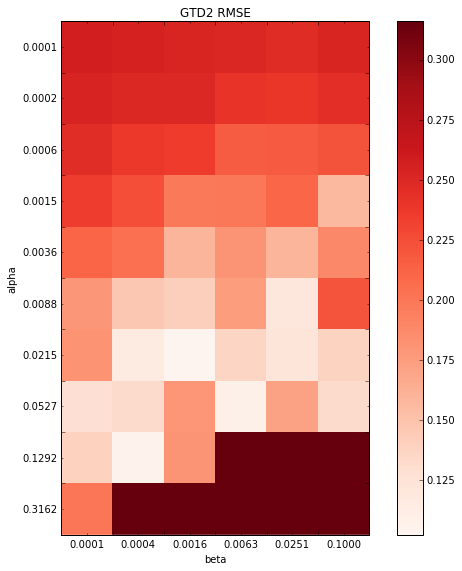

In [21]:
# Heat map
_df = df_gtd2.copy()
xname = 'beta'
yname = 'alpha'

aa = np.sort(_df[xname].unique())
bb = np.sort(_df[yname].unique())
zz = _df['mean']
zz[zz > 1] = zz[zz < 1].max()

mat = np.zeros((len(aa), len(bb)))
for i, a in enumerate(aa):
    for j, b in enumerate(bb):
        val = zz[(_df[xname] == a) & (_df[yname] == b)].values
        mat[i,j] = val.mean()

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(mat.T, interpolation='none', cmap='Reds')

# Format the plot
ax.set_title('GTD2 RMSE')
ax.set_xlabel(xname)
ax.set_ylabel(yname)

# X-Axis ticks & labels
ax.set_xticks(np.arange(len(aa))-0.5)
ax.set_xticklabels([], visible=False)
ax.set_xticks(np.arange(len(aa)), minor=True)
ax.set_xticklabels(["{:2.4f}".format(i) for i in aa], minor=True)

# Y-axis
ax.set_yticks(np.arange(len(bb))-0.5)
ax.set_yticklabels([], visible=False)
ax.set_yticks(np.arange(len(bb)), minor=True)
ax.set_yticklabels(["{:2.4f}".format(i) for i in bb], minor=True)

# add a colorbar
fig.colorbar(cax)

plt.tight_layout()
plt.show()

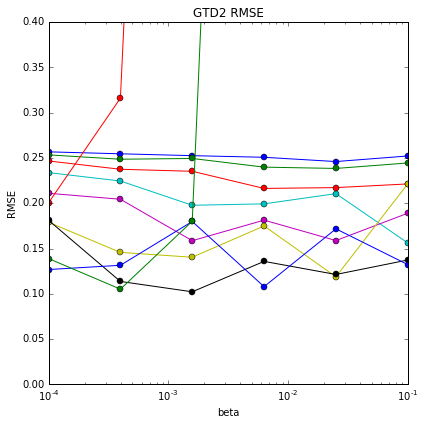

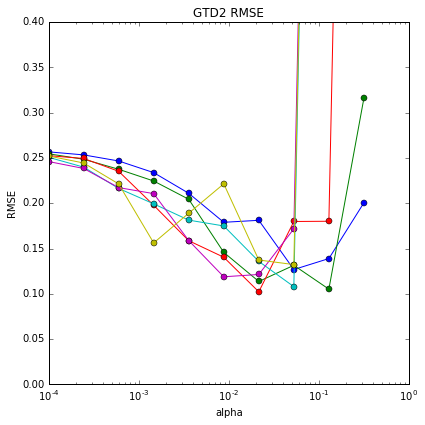

In [22]:
# One curve for each value of alpha
fig, ax = plt.subplots(1, figsize=(6,6))

groups = df.groupby('alpha')
for name, group in groups:
    length = len(group)
    xx = group['beta']
    yy = group['mean']
    ax.errorbar(xx, yy, fmt='-o')
    
    # format the graph
    ax.set_xscale('log')
    ax.set_xlim([xx.min(), xx.max()])
    ax.set_ylim([0, 0.4])
    
# Formatting
ax.set_title('GTD2 RMSE')
ax.set_xlabel('beta')
ax.set_ylabel('RMSE')
    
plt.tight_layout()
plt.show()

# One curve for each value of beta
fig, ax = plt.subplots(1, figsize=(6,6))

groups = df.groupby('beta')
for name, group in groups:
    length = len(group)
    xx = group['alpha']
    yy = group['mean']
    ax.errorbar(xx, yy, fmt='-o')
    
    # format the graph
    ax.set_xscale('log')
    ax.set_xlim([xx.min(), 1])
    ax.set_ylim([0, 0.4])
    
# Formatting
ax.set_title('GTD2 RMSE')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
    
plt.tight_layout()
plt.show()

# TDC

In [23]:
# TDC
fixed_params = {
    'gm': gm_func,
    'gm_p': gm_p_func,
    'lm': 0.0,
    'lm_p': 0.0,
    'interest': 1.0,
}

param_grid = {
    'alpha': np.logspace(-0.5, -4, 10),
    'beta': np.logspace(-1, -4, 6),
}

cases = enumerate_params(param_grid)
ncases = len(cases)
experiment = OffPolicyExperiment(algos.TDC, env, pol_pi, pol_mu)
experiment.set_phi_class(features.RandomBinary, num_features, num_active)

df = pd.DataFrame(columns=['alpha', 'beta', 'min', 'max', 'mean', 'std', 'se'])


print("Iterating over parameters...")
for ix, case in enumerate(cases):
    print("Case #: {0:d} of {1:d}".format(ix, ncases), end='\r')
#     print('alpha: {alpha:10.6} {beta:10.6}'.format(**case))
    update_params = dict(**fixed_params, **case)
    data = experiment.run(num_runs, max_steps, update_params)
    
    dct = dict()
    dct.update(**case)
    dct.update(**summarize(data, num_last))
    
    df = df.append(dct, ignore_index=True)
    
    # is it still learning?
    avg_errors = np.mean(tail_errors(data, last=50), axis=0)
    grad = avg_errors[1:] - avg_errors[0:-1]
#     print(np.mean(grad))

# copy the dataframe in case additional analysis is desirable
df_tdc = df.copy()

# clip the 'mean' error 
df['mean'] = df['mean'].clip_upper(2)

print("Minimum error:")
print(df.sort_values('mean').head(1))

Iterating over parameters...
Minimum error:
       alpha    beta       min       max      mean       std        se
51  0.129155  0.0001  0.015888  0.209026  0.079096  0.076133  0.034048


In [24]:
df.sort_values('mean').head(5)

,alpha,beta,min,max,mean,std,se
51,0.129155,0.000100,0.015888,0.209026,0.079096,0.076133,0.034048
14,0.008799,0.025119,0.033559,0.190675,0.102463,0.059154,0.026455
33,0.021544,0.001585,0.032982,0.213972,0.113535,0.084731,0.037893
23,0.021544,0.006310,0.048505,0.202848,0.118133,0.055732,0.024924
21,0.129155,0.006310,0.035370,0.198500,0.118552,0.057950,0.025916


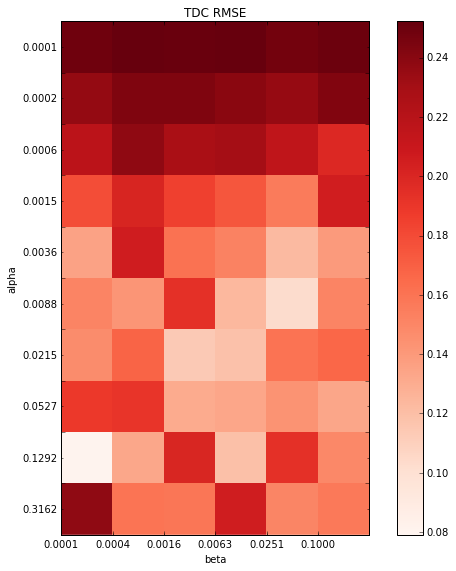

In [25]:
# Heat map
_df = df.copy()
xname = 'beta'
yname = 'alpha'

aa = np.sort(_df[xname].unique())
bb = np.sort(_df[yname].unique())
zz = _df['mean']
zz[zz > 1] = zz[zz < 1].max()

mat = np.zeros((len(aa), len(bb)))
for i, a in enumerate(aa):
    for j, b in enumerate(bb):
        val = zz[(_df[xname] == a) & (_df[yname] == b)].values
        mat[i,j] = val.mean()

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(mat.T, interpolation='none', cmap='Reds')

# Format the plot
ax.set_title('TDC RMSE')
ax.set_xlabel(xname)
ax.set_ylabel(yname)

# X-Axis ticks & labels
ax.set_xticks(np.arange(len(aa))-0.5)
ax.set_xticklabels([], visible=False)
ax.set_xticks(np.arange(len(aa))-0.5, minor=True)
ax.set_xticklabels(["{:2.4f}".format(i) for i in aa], minor=True)

# Y-axis
ax.set_yticks(np.arange(len(bb))-0.5)
ax.set_yticklabels([], visible=False)
ax.set_yticks(np.arange(len(bb)), minor=True)
ax.set_yticklabels(["{:2.4f}".format(i) for i in bb], minor=True)

# add a colorbar
fig.colorbar(cax)

plt.tight_layout()
plt.show()

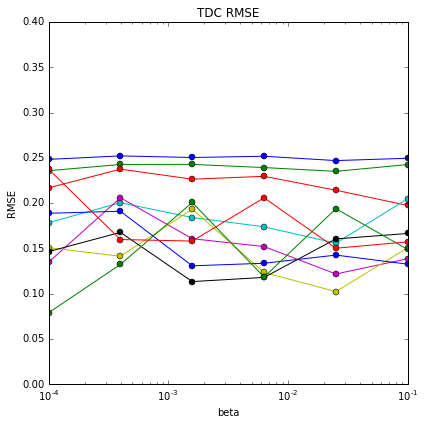

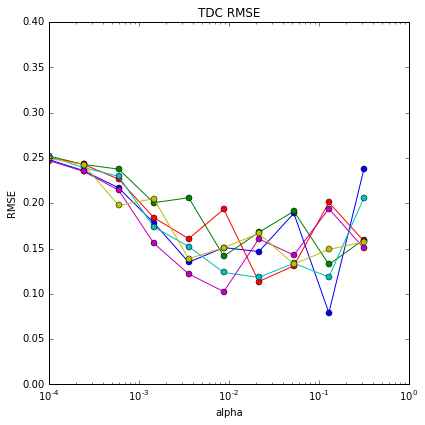

In [26]:
# One curve for each value of alpha
fig, ax = plt.subplots(1, figsize=(6,6))

groups = df.groupby('alpha')
for name, group in groups:
    length = len(group)
    xx = group['beta']
    yy = group['mean']
    ax.errorbar(xx, yy, fmt='-o')
    
    # format the graph
    ax.set_xscale('log')
    ax.set_xlim([xx.min(), xx.max()])
    ax.set_ylim([0, 0.4])
    
# Formatting
ax.set_title('TDC RMSE')
ax.set_xlabel('beta')
ax.set_ylabel('RMSE')
    
plt.tight_layout()
plt.show()

# One curve for each value of beta
fig, ax = plt.subplots(1, figsize=(6,6))

groups = df.groupby('beta')
for name, group in groups:
    length = len(group)
    xx = group['alpha']
    yy = group['mean']
    ax.errorbar(xx, yy, fmt='-o')
    
    # format the graph
    ax.set_xscale('log')
    ax.set_xlim([xx.min(), 1])
    ax.set_ylim([0, 0.4])
    
# Formatting
ax.set_title('TDC RMSE')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
    
plt.tight_layout()
plt.show()

# ETD

In [27]:
# ETD
fixed_params = {
    'gm': gm_func,
    'gm_p': gm_p_func,
    'lm': 0.0,
    'lm_p': 0.0,
    'interest': 1.0,
}

param_grid = {
    'alpha': np.logspace(-1, -4, 10),
}

cases = enumerate_params(param_grid)
ncases = len(cases)
experiment = OffPolicyExperiment(algos.ETD, env, pol_pi, pol_mu)
experiment.set_phi_class(features.RandomBinary, num_features, num_active)

df = pd.DataFrame(columns=['alpha', 'min', 'max', 'mean', 'std', 'se'])

for ix, case in enumerate(cases):
    print("Case #: {0:d} of {1:d}".format(ix, ncases), end='\r')
    update_params = dict(**fixed_params, **case)
    data = experiment.run(num_runs, max_steps, update_params)
    
    dct = dict()
    dct.update(**case)
    dct.update(**summarize(data, num_last))
    
    df = df.append(dct, ignore_index=True)
    
    # is it still learning?
    avg_errors = np.mean(tail_errors(data, last=50), axis=0)
    grad = avg_errors[1:] - avg_errors[0:-1]
#     print(np.mean(grad))
    
param_grid = {
    'alpha': np.logspace(-0.5, -4, 10),
}

# copy the dataframe in case additional analysis is desirable
df_etd = df.copy()

# clip the 'mean' error 
df['mean'] = df['mean'].clip_upper(2)

# the lowest available error
print(df.sort_values('mean').head(1))

      alpha       min       max      mean       std        se
8  0.000215  0.032204  0.073349  0.048216  0.015283  0.006835


In [28]:
df.sort_values('mean').head(3)

,alpha,min,max,mean,std,se
8,0.000215,0.032204,0.073349,0.048216,0.015283,0.006835
7,0.000464,0.032483,0.069615,0.050357,0.014359,0.006422
4,0.004642,0.025200,0.093615,0.052314,0.025177,0.011260


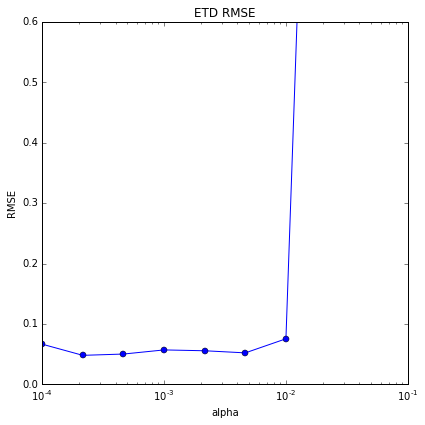

In [29]:
# _df = df[df['mean'] < 1.0]
_df = df.copy() 
_df = _df.sort_values('alpha')
xx = _df['alpha'].values
yy = _df['mean'].values
yerr = _df['se'].values

fig, ax = plt.subplots(figsize=(6,6))
ax.errorbar(xx, yy, fmt='-o')
ax.set_ylim([0, 0.6])
ax.set_xscale('log')

# Formatting
ax.set_title('ETD RMSE')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')

plt.tight_layout()
plt.show()

In [31]:
store = pd.HDFStore('_off_policy_search_long.h5', 'w')
store['gtd'] = df_gtd
store['gtd2'] = df_gtd2
store['tdc'] = df_tdc
store['etd'] = df_etd
store.close()

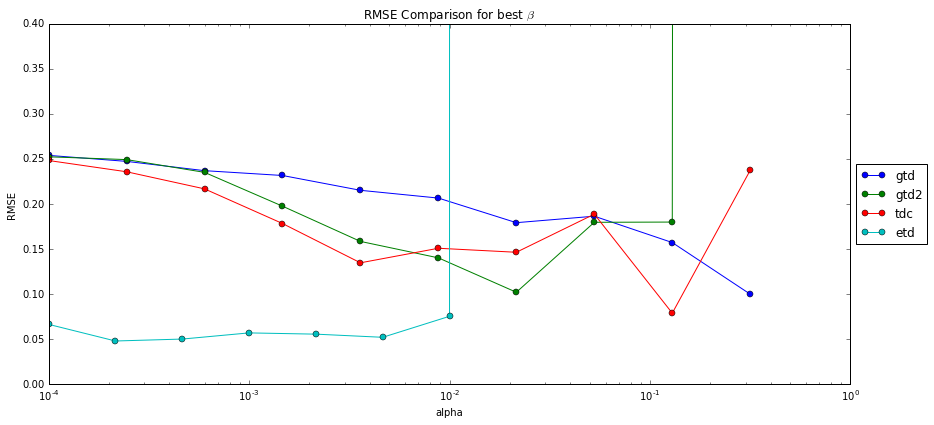

In [52]:
store = pd.HDFStore('_off_policy_search_long.h5', 'r')

fig, ax = plt.subplots(figsize=(12,6))

for k in ['gtd', 'gtd2', 'tdc']:
    df = store.select(k)
    
    # Find the best value of beta
    best_beta = None
    low_mean = 100
    for b, group in df.groupby('beta'):
        group_mean = group['mean'].min()
        if group_mean < low_mean:
            best_beta = b
            low_mean = group_mean
            
    beta_group = df[df['beta'] == best_beta]
    xx = beta_group['alpha'].values
    yy = beta_group['mean'].values
    ax.errorbar(xx, yy, fmt='-o', label=k)
    
# Plot alpha values from ETD
xx = store['etd']['alpha'].values
yy = store['etd']['mean'].values
ax.errorbar(xx, yy, fmt='-o', label='etd')
    
# format the graph
ax.set_xscale('log')
ax.set_xlim([xx.min(), 1])
ax.set_ylim([0, 0.4])
    
# Formatting
ax.set_title(r'RMSE Comparison for best $\beta$')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')

# Add legend
ax.legend()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()